# RNN models lab

Idea: RNNs, iike CNNs, are "pattern detectors".

RNNs detect patterns by remembering what has been seen before.  They maintain state that partially records all previous inputs.

**Instructions**:
- work with your team
- look for problem numbers below

In [20]:
import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [21]:
# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 600)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [22]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = 4,3

This custom callback allows for training to stop when a high accuracy is achieved.

Source: https://stackoverflow.com/questions/53500047/stop-training-in-keras-when-accuracy-is-already-1-0

In [23]:
class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

### Create artificial data set

Two classes: sawtooth and sine wave.

A common way to create synthetic data sets is to start by producing the "true data", and then to add noise.

#### Create base patterns -- the "true data".

In [24]:
num_classes = 2
n = 10   # number of time steps

pattern = np.zeros((num_classes, n))

# sawtooth
x = []
y = 0.0
for i in range(n):
    x.append(y)
    if i < n/2:
        y += 0.2
    else:
        y -= 0.2
pattern[0] = x

# sin wave
pattern[1] = np.sin(np.linspace(0, np.pi*2, n))*0.5 + 0.5

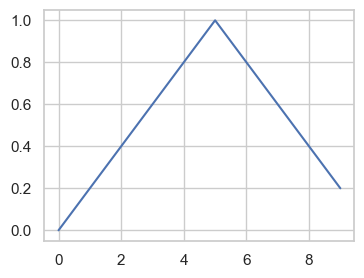

In [25]:
plt.plot(pattern[0]);

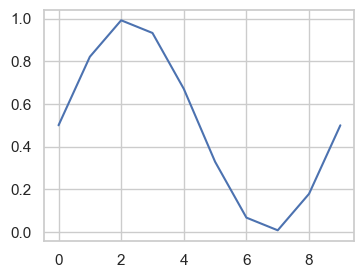

In [26]:
plt.plot(pattern[1]);

#### Create data by adding noise

In [53]:
instances_per_class = 15000
m = num_classes * instances_per_class

In [54]:
X = np.zeros((m, n))
y = np.zeros(m)
for i in range(num_classes):
    for j in range(instances_per_class):
        X[i*instances_per_class+j] = pattern[i] + np.random.normal(scale=0.05, size=n)
        y[i*instances_per_class+j] = i

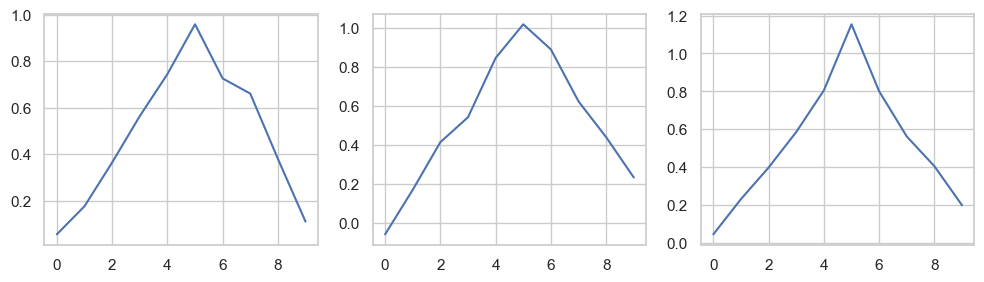

In [55]:
fig,axs = plt.subplots(1, 3, figsize=(12,3))
for i in range(len(axs)):
    axs[i].plot(X[i])
plt.show()

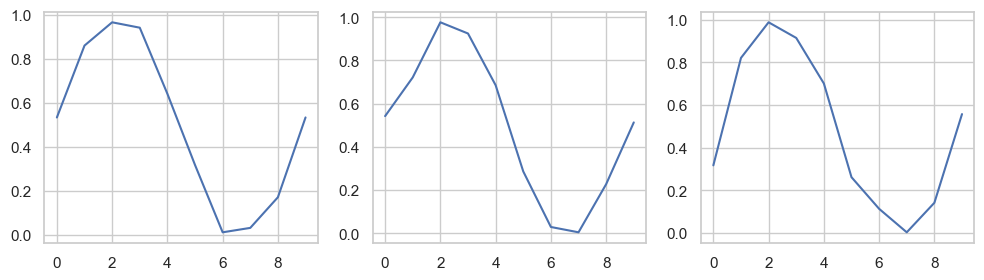

In [56]:
fig,axs = plt.subplots(1, 3, figsize=(12,3))
for i in range(len(axs)):
    axs[i].plot(X[instances_per_class+i])
plt.show()

#### Train/test split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Create a simple binary classifier

In [58]:
K.clear_session()

#### Problem 1.  Create a binary classifier using 1 recurrent neuron.

In [59]:
inputs = Input(shape=(n,1))
x = layers.SimpleRNN(1)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

In [60]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

In [61]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

This callback will stop the training process if a very high validation accuracy is achieved.

In [62]:
stop_on_high_accuracy = TerminateOnBaseline(monitor='val_accuracy', baseline=0.999)

#### Problem 2. Train the model.  Decide for yourself on the number of epochs and the batch size.

I recommend using the stop_on_high_accuracy callback.

In [63]:

with tf.device('/CPU:0'):
    model.fit(X_train, y_train, epochs=5000, batch_size=16, validation_split=0.3, callbacks=[stop_on_high_accuracy])

Epoch 1/5000
914/919 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6907 - loss: 0.6662Epoch 0: Reached baseline, terminating training
919/919 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6918 - loss: 0.6660 - val_accuracy: 1.0000 - val_loss: 0.5755


#### Problem 3.  Use model.evaluate() to compute the test accuracy of the classifier.  Use the test set.

In [64]:
model.evaluate(X_test, y_test)

282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9996 - loss: 0.5758


[0.5754502415657043, 0.9997777938842773]

#### Problem 4. Print the model layers

In [65]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <SimpleRNN name=simple_rnn, built=True>,
 <Dense name=dense, built=True>]

#### Problem 5.  Get and print the weights of the rnn layer and dense layer.

In [66]:
rnn_weights   = model.get_layer('simple_rnn').get_weights()
dense_weights = model.get_layer('dense').get_weights()

In [67]:
print(rnn_weights)
print(dense_weights)

[array([[-0.51197284]], dtype=float32), array([[0.89664125]], dtype=float32), array([0.22215715], dtype=float32)]
[array([[1.562894]], dtype=float32), array([0.06010143], dtype=float32)]


#### Problem 6. Print the shapes of the weights of the rnn layer and dense layer.

In [42]:
print(rnn_weights[0].shape)
print(dense_weights[0].shape)

(1, 1)
(1, 1)


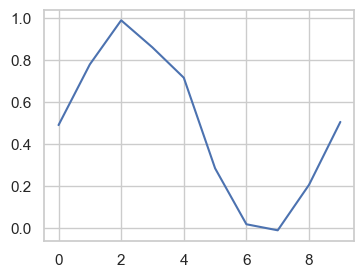

In [68]:
plt.plot(X_train[0]);

#### Problem 7.  Using the model, predict the probability of class 1 for input X_train[0].

In [44]:
model.predict(X_train[[0]]).round(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


array([[0.54142]], dtype=float32)

In [45]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [46]:
def binary_rnn_predict(rnn_weights, dense_weights, x):
    
    w = rnn_weights[0][0,0]
    u = rnn_weights[1][0,0]
    rnn_bias = rnn_weights[2][0]
    v = dense_weights[0][0,0]
    dense_bias = dense_weights[1][0]
    
    # rnn 
    hidden_state = 0.0
    for t in range(x.shape[0]):
        hidden_state = np.tanh(w * x[t] + u * hidden_state + rnn_bias)
       
    # output layer
    return sigmoid(v * hidden_state + dense_bias)

#### Problem 8.  Using binary_rnn_predict, predict the probability of class 1 for input X_train[0].

In [47]:
binary_rnn_predict(rnn_weights, dense_weights, X_train[0]).round(4)

0.5414

In [69]:
def binary_rnn_predict(rnn_weights, dense_weights, x):

    w          = rnn_weights[0][0,0]   	# RNN input weight
    u          = rnn_weights[1][0,0]   	# RNN hidden state weight
    rnn_bias   = rnn_weights[2][0]	# RNN bias
    v          = dense_weights[0][0,0]	# dense layer weight
    dense_bias = dense_weights[1][0]	# dense layer bias

    # rnn 
    hidden_state = 0.0
    for t in range(x.shape[0]):  # time t
        hidden_state = np.tanh(w * x[t] + u * hidden_state + rnn_bias)
        print(f"{t} : {hidden_state}")
      

    # output layer
    return sigmoid(v * hidden_state + dense_bias)


In [73]:
binary_rnn_predict(rnn_weights, dense_weights, X_train[0])

0 : -0.02908539799089936
1 : -0.20048061712367485
2 : -0.43360968560936064
3 : -0.5421649540856412
4 : -0.5585577901807715
5 : -0.4007621118300152
6 : -0.1456380416527864
7 : 0.09648361825593701
8 : 0.2001797678650397
9 : 0.14165975617489163


0.569914079577832